**Template from:** https://towardsdatascience.com/7-steps-to-a-successful-data-science-project-b452a9b57149

# **1. Definição do Problema**

Your objective as a consultant is to decrease the maintenance costs of this particular (air) system. Maintenance costs for the air system may vary depending on the actual condition of the truck.

- If a truck is sent for maintenance, but it does not show any defect in this system, around $10 will be charged for the time spent during the
inspection by the specialized team. 
- If a truck is sent for maintenance and it is defective in this system, $25 will be charged to perform the preventive repair service.
- If a truck with defects in the air system is not sent directly for maintenance, the company pays $500 to carry out corrective
maintenance of the same, considering the labor, replacement of parts and other possible inconveniences (truck broke down in the middle of
the track for example).

During the alignment meeting with those responsible for the project and the company's IT team, some information was given to you:
- The technical team informed you that all information regarding the air system of the paths will be made available to you, but for bureaucratic reasons regarding company contracts, all columns had to be encoded.
- The technical team also informed you that given the company's recent digitization, some information may be missing from the database sent to
you.

Finally, the technical team informed you that the source of information comes from the company's maintenance sector, where they created a column in the database called **class: "pos"** would be those trucks that had defects in the air system and **"neg"** would be those trucks that had a defect in any system other than the air system.


Those responsible for the project are very excited about the initiative and, when asking for a technical proof of concept, they have put forth as **main requirements:**
- Can we reduce our expenses with this type of maintenance using AI
techniques?
- Can you present to me the main factors that point to a possible failure in
this system?

# 2. **Obtendo os dados**

## 2.1. Bibliotecas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

## 2.2. Funções

## 2.3. Carregando os dados

In [4]:
df_train = pd.read_csv('data/air_system_previous_years.csv')
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [5]:
# df_test = pd.read_csv('data/air_system_present_year.csv')
# df_test.shape

O dataset do ano atual tem a mesma quantidade de features, porém tem menos ocorrências (linhas). Ele será usado como dataset de teste, enquanto os dados dos anos anteriores serão usados para treinamento.

# **3. Data Cleaning**

In [6]:
df_train.shape

(60000, 171)

**Perceba que o dataset tem 60 mil linhas e 171 colunas (features)**, incluindo a variável resposta ('class').

### **Substituindo valores da coluna 'class' por binários**

In [7]:
df_train['class'] = df_train['class'].replace(['pos','neg'],[1,0]).astype(int)

/tmp/ipykernel_117844/1578300272.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['class'] = df_train['class'].replace(['pos','neg'],[1,0]).astype(int)


### **Verificando se a variável resposta está desbalanceada**

/tmp/ipykernel_117844/2239150361.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)#hue=class_counts, legend=False)


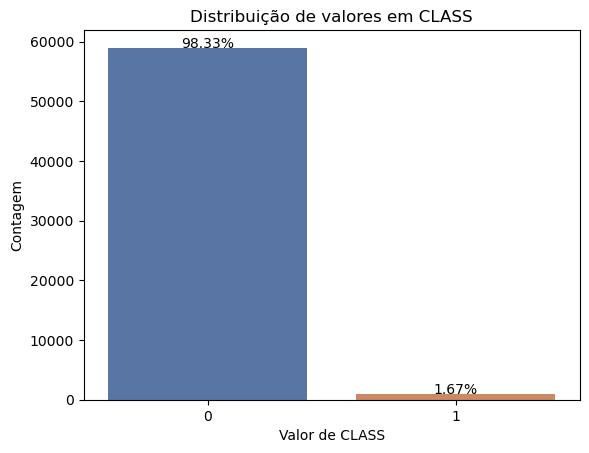

Número de positivos:  1000
Número de negativos:  59000


In [8]:
# Plotando a distribuição de valores da nossa variável resposta 'class'
class_counts = df_train['class'].value_counts()
total = class_counts.sum()

# Criando uma paleta de cores personalizada
palette = sns.color_palette("deep", len(class_counts))

# Plotando o gráfico com cores diferentes para cada barra
ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette)#hue=class_counts, legend=False)
plt.title('Distribuição de valores em CLASS')
plt.xlabel('Valor de CLASS')
plt.ylabel('Contagem')

# Adicionando os valores percentuais acima de cada barra
for i, count in enumerate(class_counts):
    percentage = f'{(count / total) * 100:.2f}%'
    ax.text(i, count + 0.05, percentage, ha='center')

plt.show()
plt.savefig('img/class_dist.png')
plt.close()

print('Número de positivos: ', class_counts[1])
print('Número de negativos: ', class_counts[0])

**O dataset é extremamente desbalanceado**, com a maioria dos valores de CLASS sendo negativos.

### **Substituindo os valores faltantes 'na' por Nan**

In [9]:
df_train = df_train.replace('na',np.NaN)
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0,76698,NaN,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,NaN,0,NaN,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,NaN,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,NaN,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


### **Removendo features com apenas um único valor**
Essas features não são relevantes para o treinamento dos modelos.

In [10]:
# Primeiro converte o dataframe inteiro para formato numérico (float)
df_train = df_train.astype(float)

# Agora avalia quais colunas têm desvio-padrão zero = sem variância
for i in df_train:
  if df_train[i].std() == 0:
    df_train = df_train.drop([i],axis=1)
    print('A feature com variância zero é: ',i)

df_train.shape

A feature com variância zero é:  cd_000


(60000, 170)

Apenas uma feature tinha variância zero e foi removida.

### **Removendo duplicadas**

In [11]:
# remove colunas duplicadas
df_train = df_train.drop_duplicates(keep = 'first')

# remove linhas duplicadas (primeira transposição) e depois reformata o dataframe para o original (segunda transposição)
df_train = df_train.T.drop_duplicates().T

print(df_train.shape)

(59999, 170)


Apenas uma linha foi removida. Nenhuma coluna duplicada foi encontrada.

### **Limpeza do dataset de treino**
Faremos com ele todas as etapas feitas até aqui com o dataset de treino.

In [12]:
# df_test['class'] = df_test['class'].replace(['pos','neg'],[1,0])
# df_test = df_test.replace('na',np.NaN)
# df_test = df_test.astype(float)
# for i in df_test:
#   if df_test[i].std() == 0:
#     df_test = df_test.drop([i],axis=1)
#     print('The feature with zero variance is : ',i)

# df_test = df_test.drop_duplicates(keep = 'first')
# df_test = df_test.T.drop_duplicates().T
# print(df_test.shape)

# **4. Exploratory Data Analysis (EDA)**

### **Verificando quantidade de valores faltantes**

In [13]:
# verifica quantidade de nulos de cada coluna exceto 'class'
valores_faltantes = dict(df_train.drop('class',axis=1).isnull().sum())


valores_faltantes = dict(sorted(valores_faltantes.items(), key=lambda item:item[1],reverse=True))

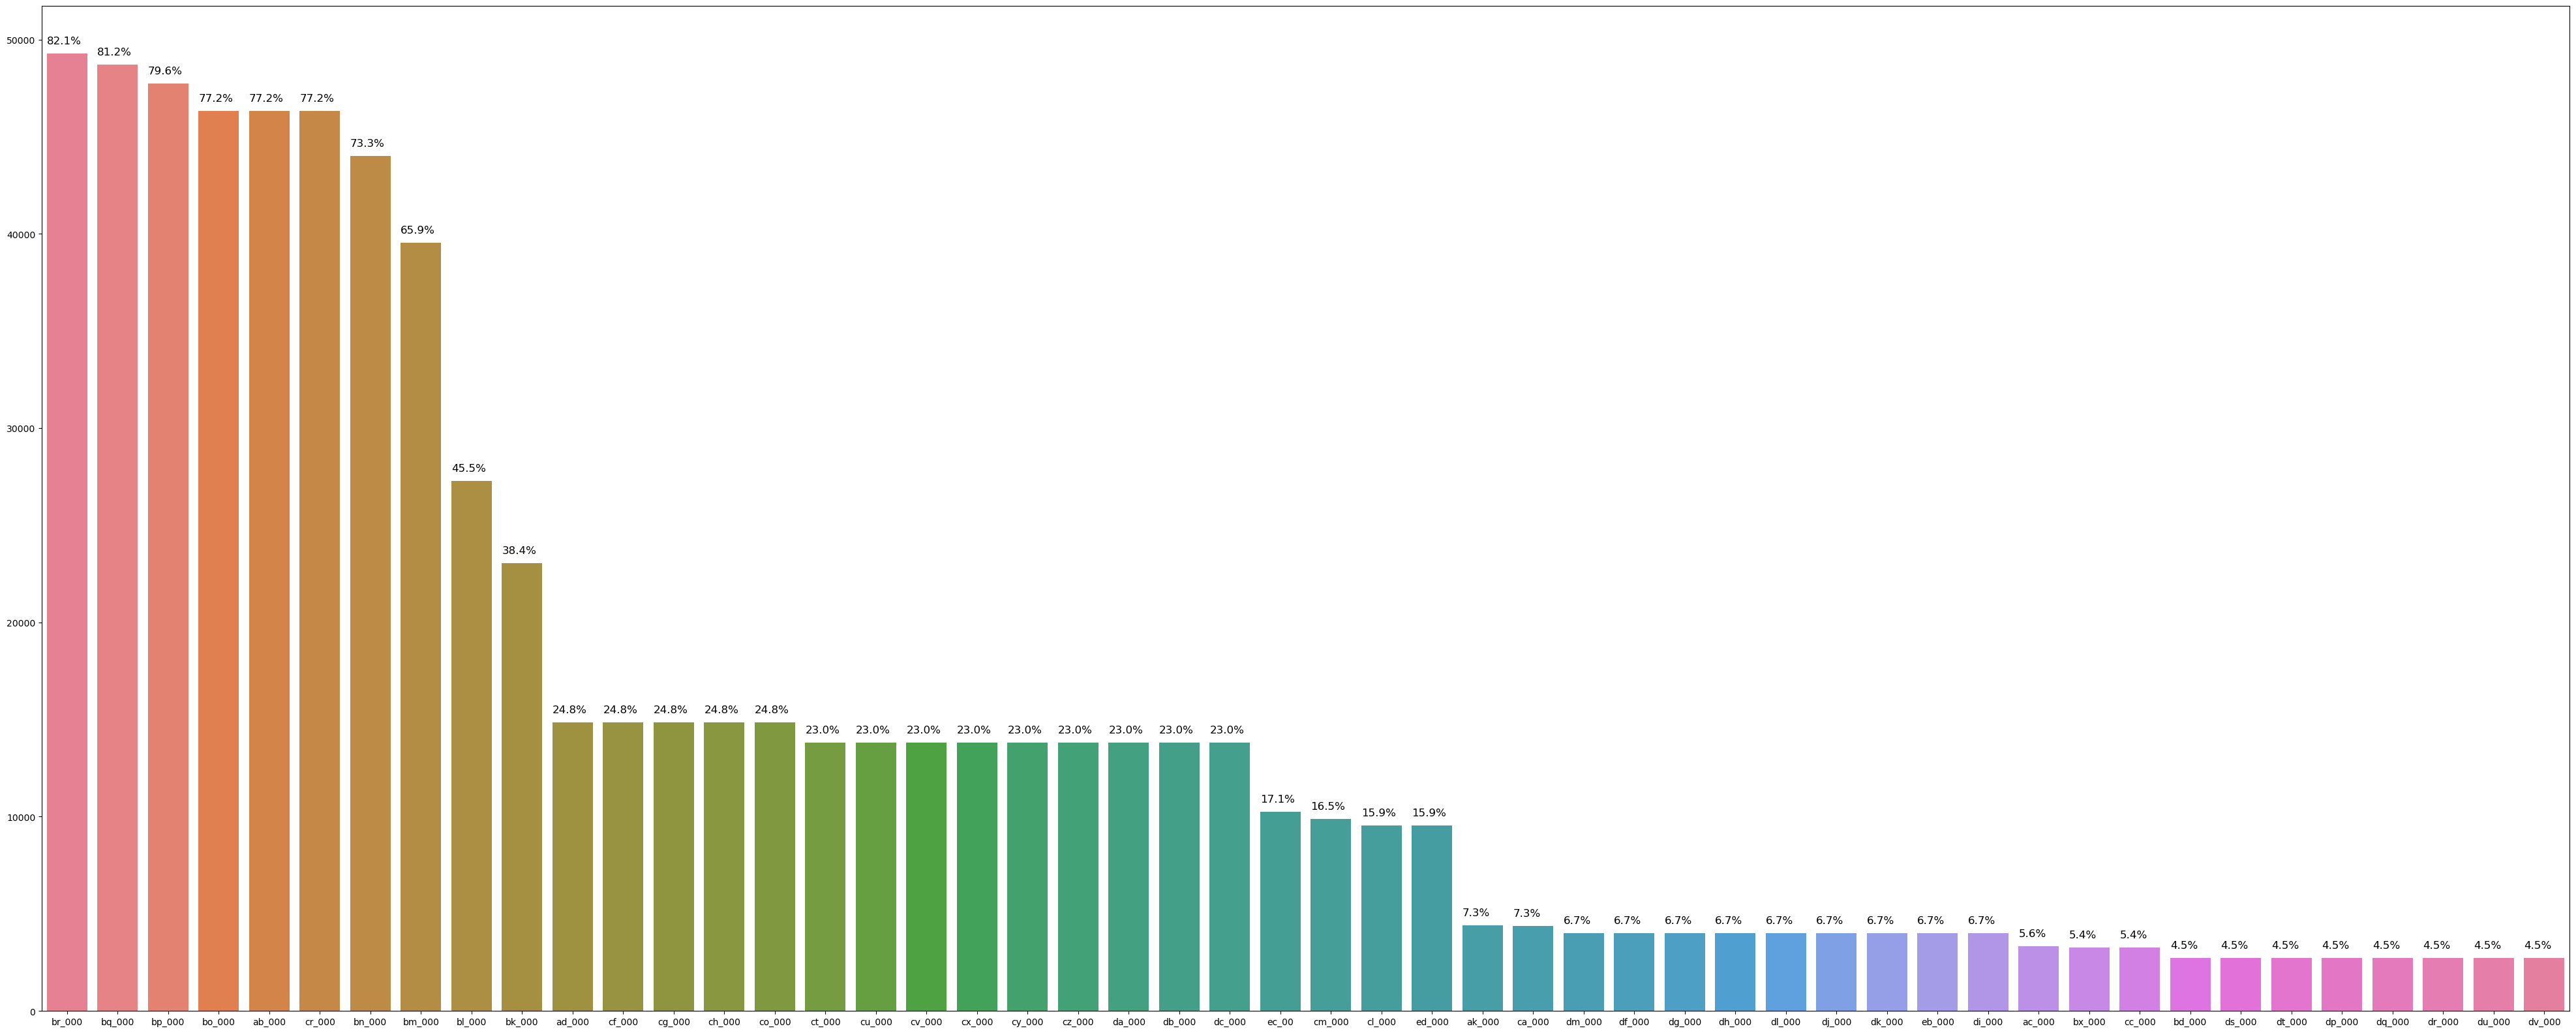

In [14]:
# plotando gráfico de barras com % de nulos nas 50 colunas com mais valores nulos
def barplot(data,sum):
  plt.figure(figsize = (50,20))
  ax = sns.barplot(x = list(data.keys())[:50], y = list(data.values())[:50], hue=list(data.keys())[:50], legend=False)

  for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/sum)
    x = p.get_x() 
    y = p.get_height()+500
    ax.annotate(percentage,(x,y),size=12)
  
  plt.show()
  plt.savefig('img/count_null.png')
  plt.close()

barplot(valores_faltantes,df_train.shape[0])

Conforme o gráfico acima, o dataset tem 8 features com mais de 60% de valores nulos; 16 features entre 20-60% nulos; e todas as restantes com menos de 20% nulos.

### **Separando features de histograma do dataset**
As features estão com nomes codificados. Os nomes no formato 'letras_000' são números. Os nomes no formato 'letras_00x' são intervalos (*bins*) de histogramas.

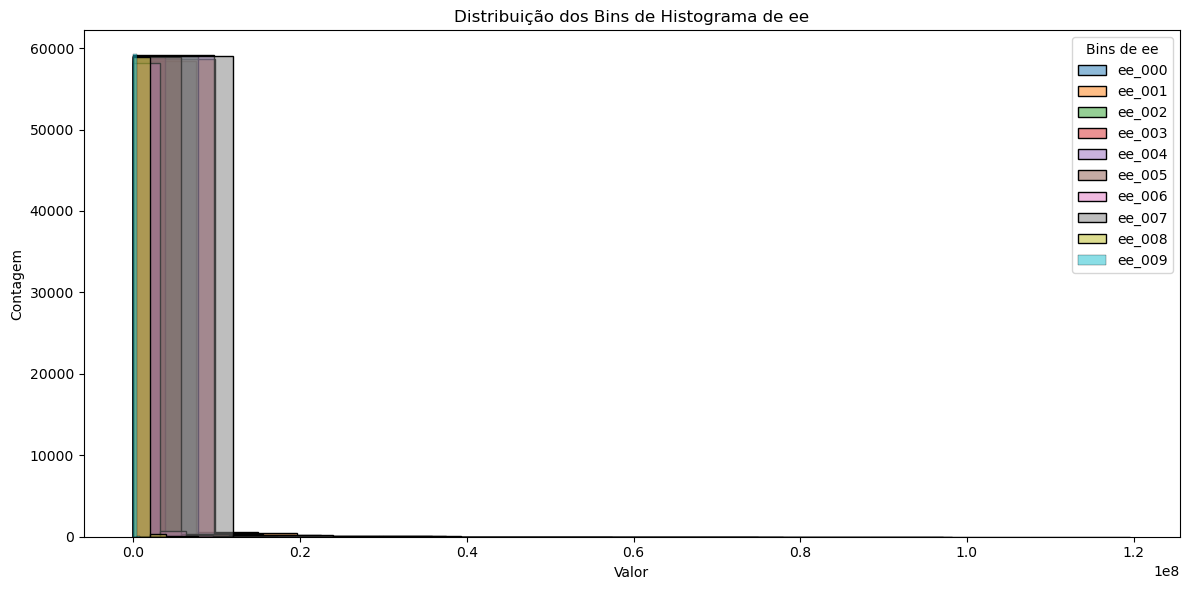

In [20]:
# Exemplo de features que representam bins de um histograma: features começadas com 'ee'

# Selecionando apenas as features que representam bins de histogramas
features_bins = ['ee_000', 'ee_001', 'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008', 'ee_009']

# Agrupando as features pelo prefixo 'ee'
df_ee = df_train[features_bins]

# Plotando histogramas para cada grupo de features
plt.figure(figsize=(12, 6))
for col in df_ee.columns:
    sns.histplot(df_ee[col], bins=10, kde=False, alpha=0.5, label=col)

plt.title('Distribuição dos Bins de Histograma de ee')
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.legend(title='Bins de ee')
plt.tight_layout()
plt.show()
plt.savefig('img/hist_feature_ee.png')
plt.close()


In [21]:
# Separando as features que são bins de histograma
hist_col = []
for i in df_train.columns:
  if i[-1] != '0': # se o último dígito do nome da coluna não é zero, então representa bin de histograma
    hist_col.append(i)

hist_col.extend(['ag_000','ay_000','az_000','ba_000','cn_000','cs_000','ee_000']) # adiciona outras features que representam bin mas que terminam em zero

hist_features = df_train[hist_col]
hist_features = hist_features.drop('class',axis=1) # exclui a variável resposta do conjunto de colunas que representam bins
num_features = df_train.drop(hist_col,axis=1) # features numéricas = dataframe sem as colunas de bins de histogramas


print(hist_features.shape)
print(num_features.shape)

(59999, 70)
(59999, 99)


Observe que existem 70 features que representam bins de histogramas e 99 features numéricas.

### **Extraindo features importantes**

- Como existem muitas features, será preciso selecionar as mais relevantes antes de realizar a EDA delas.
- Usarei o *Recursive Feature Elimination* (RFE). Ele é simples de utilizar e eficiente para selecionar features (https://machinelearningmastery.com/rfe-feature-selection-in-python/).
- Como ele funciona? De maneira resumida, ele utiliza um algoritmo de ML para rankear features e elimina aquelas com menor score. Em seguida, ele reaplica o algoritmo nas features remanescentes, repetindo o processo de eliminação até restarem apenas a quantidade de features desejadas.
- O ideal seria fazer uma seleção de algoritmos e números de features com melhor performance do RFE, mas dado o tamanho do dataset, meus recursos computacionais e o prazo disponível, vejamos como será o desempenho desta versão básica (10 top features de cada tipo - numérica ou histograma, usando algoritmo random forest). O artigo (https://machinelearningmastery.com/rfe-feature-selection-in-python/) explica como implementar essa seleção.


#### Obtendo as features mais importantes de histogramas

In [22]:
# Definindo o RFE

def top_features_rfe(X,y,n):
  estimator = RandomForestClassifier(max_depth=5) # algoritmo de ML escolhido para rankear as features
  rfe = RFE(estimator = estimator, n_features_to_select=n, verbose=0)
  rfe.fit(X,y)
  return (rfe.support_)

In [23]:
# Obtendo as features mais importantes

hist_features['class'] = df_train['class']
imp_hist_features = hist_features.dropna()
y = imp_hist_features['class'] 
X = imp_hist_features.drop('class',axis=1)
top_hist_features_rfe = top_features_rfe(X,y,10) # procura as 10 features mais importantes
top_hist_features=[];
hist_col = X.columns

for i in range(len(hist_col)):
  if top_hist_features_rfe[i]:
    top_hist_features.append(hist_col[i]) 

print("Top histogram features are : ", top_hist_features)
print("Total no of important features :", len(top_hist_features))

Top histogram features are :  ['ag_001', 'ag_002', 'ag_003', 'ay_005', 'ba_004', 'cs_002', 'ee_005', 'ba_000', 'cn_000', 'ee_000']
Total no of important features : 10


In [24]:
top_hist_features

['ag_001',
 'ag_002',
 'ag_003',
 'ay_005',
 'ba_004',
 'cs_002',
 'ee_005',
 'ba_000',
 'cn_000',
 'ee_000']

#### Obtendo as features numéricas mais importantes:

In [25]:
num_features['class'] = df_train['class']
imp_num_features = num_features.dropna()
y = imp_num_features['class']
X = imp_num_features.drop('class',axis=1)
top_num_features_rfe = top_features_rfe(X,y,10) # seleciona as top 10 features numéricas mais importantes
top_num_features=[];
hist_col = X.columns
for i in range(len(hist_col)):
  if top_num_features_rfe[i]:
    top_num_features.append(hist_col[i]) 

print("Features numéricas mais importantes: ", top_num_features)
print("Número de features numéricas mais importantes:", len(top_num_features))

Features numéricas mais importantes:  ['ai_000', 'al_000', 'am_0', 'aq_000', 'bg_000', 'bh_000', 'bj_000', 'cj_000', 'df_000', 'dn_000']
Número de features numéricas mais importantes: 10


Agora podemos começar a EDA. Ela será executada apenas sobre as features mais importantes que selecionamos acima.

### **EDA - Features de Histogramas**

#### **Análise Univariada**
Features vs Target

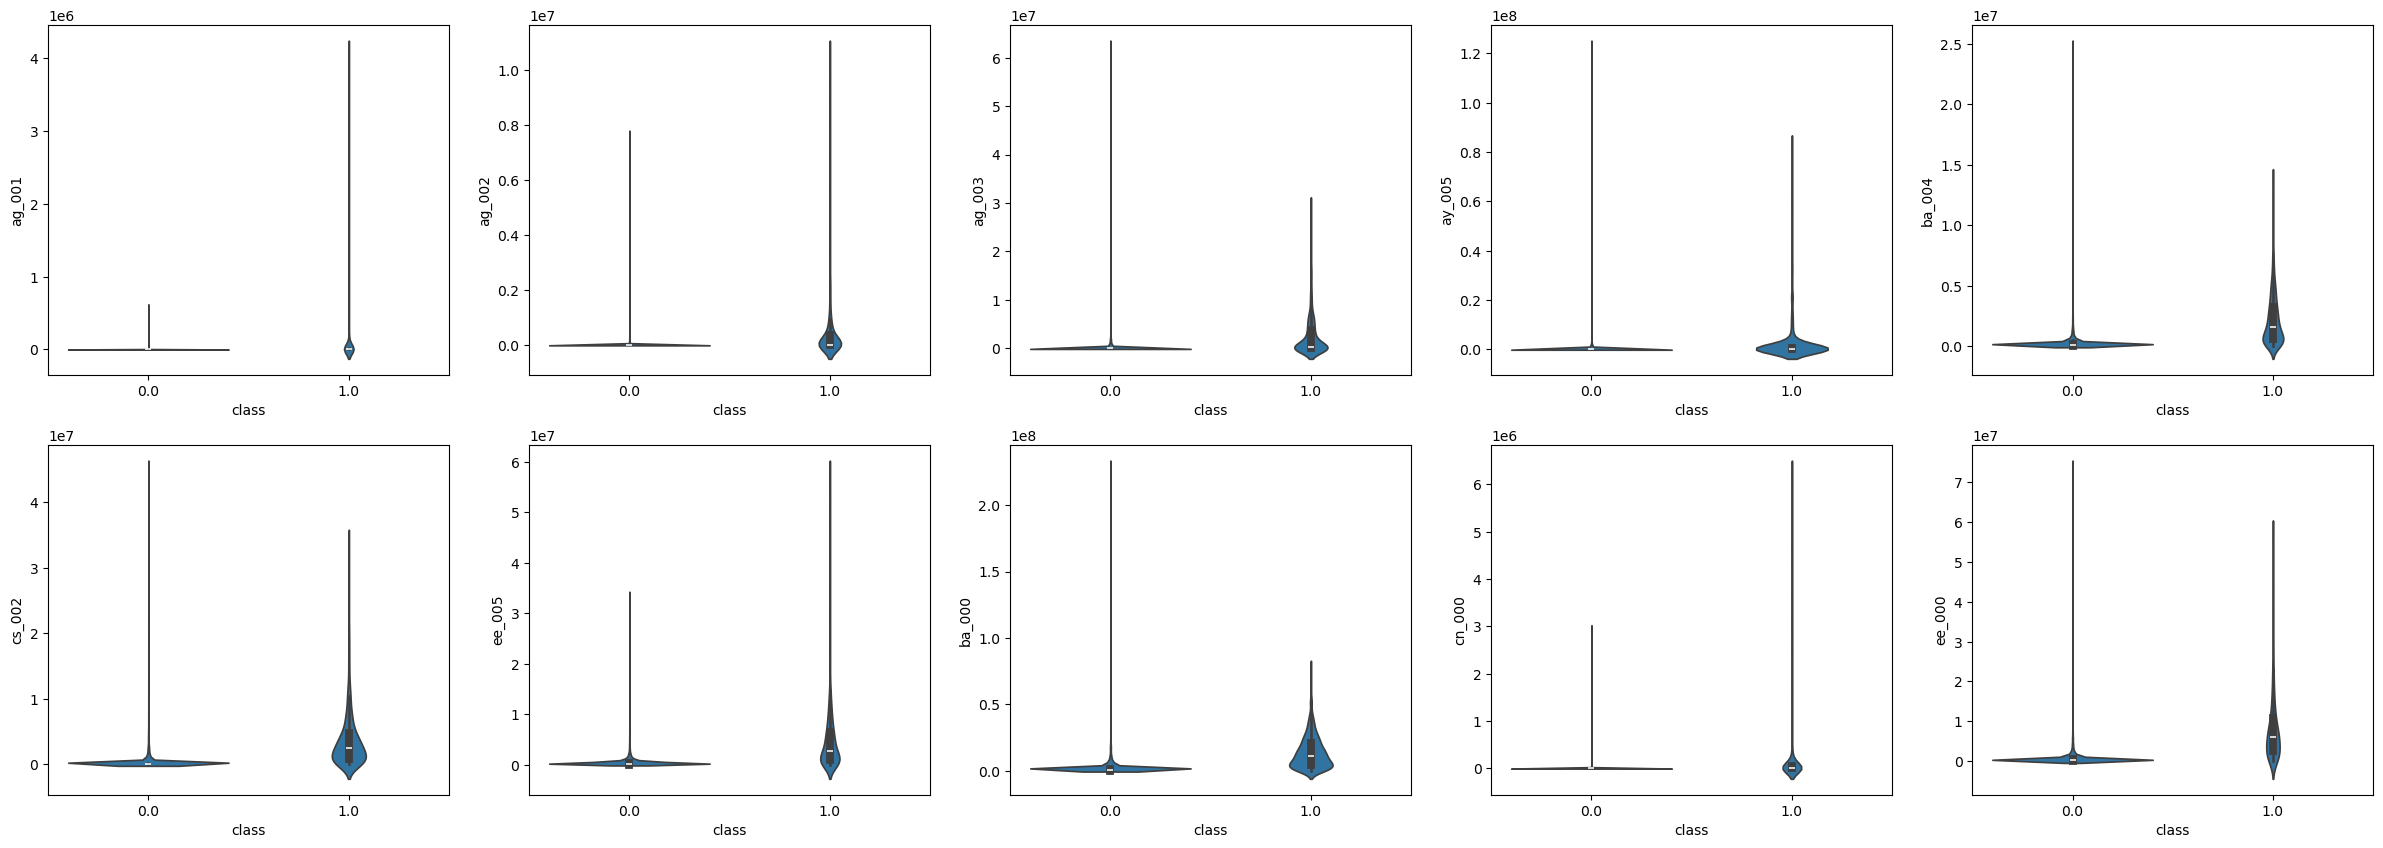

In [31]:
# violin plot para comparar features x target

def violin(df,features,row,col):
  k=0
  fig,axes = plt.subplots(row,col,figsize=(30,10))
  for i in range(len(axes)):
    for j in range(len(axes[0])):
      
      # plotando
      sns.violinplot(x=df['class'],y=features[k], ax= axes[i][j], data=df)#,size=5)
      if k!= len(features)-1:
        k+=1
      else:
        break
  plt.show()
  plt.savefig('img/violinplots_hist.png')
  plt.close()

violin(hist_features,top_hist_features,2,5)

**Análise**:
- Quando a classe é 0, os valores das features tendem a ser bem menores (em torno de zero também).
- Quando o valor da feature aumenta, aumenta a chance da classe ser 1.
- As features ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000'] têm pouquíssimos valores quando a classe é zero (IQR quase invisível), mas têm vários valores quando a classe é 1.
- As outras features têm valores em torno de zero quando a classe é zero. Logo, se o valor dessas features estiver próximo de zero, é muito provável que a classe será 0.

Como a **dispersão** é maior quando a classe é 1 para as features ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000'], continuaremos o estudo com elas.

#### Analisando o percentil entre as melhores features e o target
A intenção é encontrar uma separação clara para quando o target é 0 ou 1.

In [37]:
# Features de interesse
f = ['ba_004', 'cs_002', 'ee_005', 'ba_000', 'ee_000']

for feature in f:
    # Calcular os percentis 25 e 90 para cada classe
    percentile_90_class_0 = np.nanpercentile(hist_features[hist_features['class'] == 0][feature], 90)
    percentile_25_class_1 = np.nanpercentile(hist_features[hist_features['class'] == 1][feature], 25)
    
    # Calcular a diferença percentual entre os percentis
    diff_percent = ((percentile_25_class_1 - percentile_90_class_0) / percentile_25_class_1) * 100
    
    # Imprimir os resultados
    print("\nFeature ", feature)
    print("Percentil 90 (Class 0): ", percentile_90_class_0.round(2))
    print("Percentil 25 (Class 1): ", percentile_25_class_1.round(2))
    print("Diferença percentual (Class 1 vs Class 0): ", diff_percent.round(2), "%")


Feature  ba_004
Percentil 90 (Class 0):  361734.0
Percentil 25 (Class 1):  588036.5
Diferença percentual (Class 1 vs Class 0):  38.48 %

Feature  cs_002
Percentil 90 (Class 0):  256878.4
Percentil 25 (Class 1):  864141.0
Diferença percentual (Class 1 vs Class 0):  70.27 %

Feature  ee_005
Percentil 90 (Class 0):  708216.0
Percentil 25 (Class 1):  847208.0
Diferença percentual (Class 1 vs Class 0):  16.41 %

Feature  ba_000
Percentil 90 (Class 0):  2430826.4
Percentil 25 (Class 1):  4299871.0
Diferença percentual (Class 1 vs Class 0):  43.47 %

Feature  ee_000
Percentil 90 (Class 0):  1155269.6
Percentil 25 (Class 1):  2574780.0
Diferença percentual (Class 1 vs Class 0):  55.13 %


- Perceba como os valores das features são muito menores quando Class = 0. Essa **separação** de valores conforme a classe da varíavel resposta é o que nos diz que aquela feature tem bom poder classificatório.
- Como o percentil 25 para a classe 1 é maior que o percentil 90 para a classe zero, significa que **75% dos casos podem ser classificados corretamente, com 10% de margem de erro**, utilizando essas features.
- Considere a feature cs_002, por exemplo: em 75% das vezes em que Class = 1, o valor da feature é maior que 864.141.  Logo, se em um caso essa feature apresentar valor acima de 864.141, é muito provável que Class será igual a 1. Mas você precisa lembrar que, quando Class = 0, há uma chance de 10% do valor dessa feature ser maior que 256.878. Por isso, essa é a nossa margem de erro aproximada.

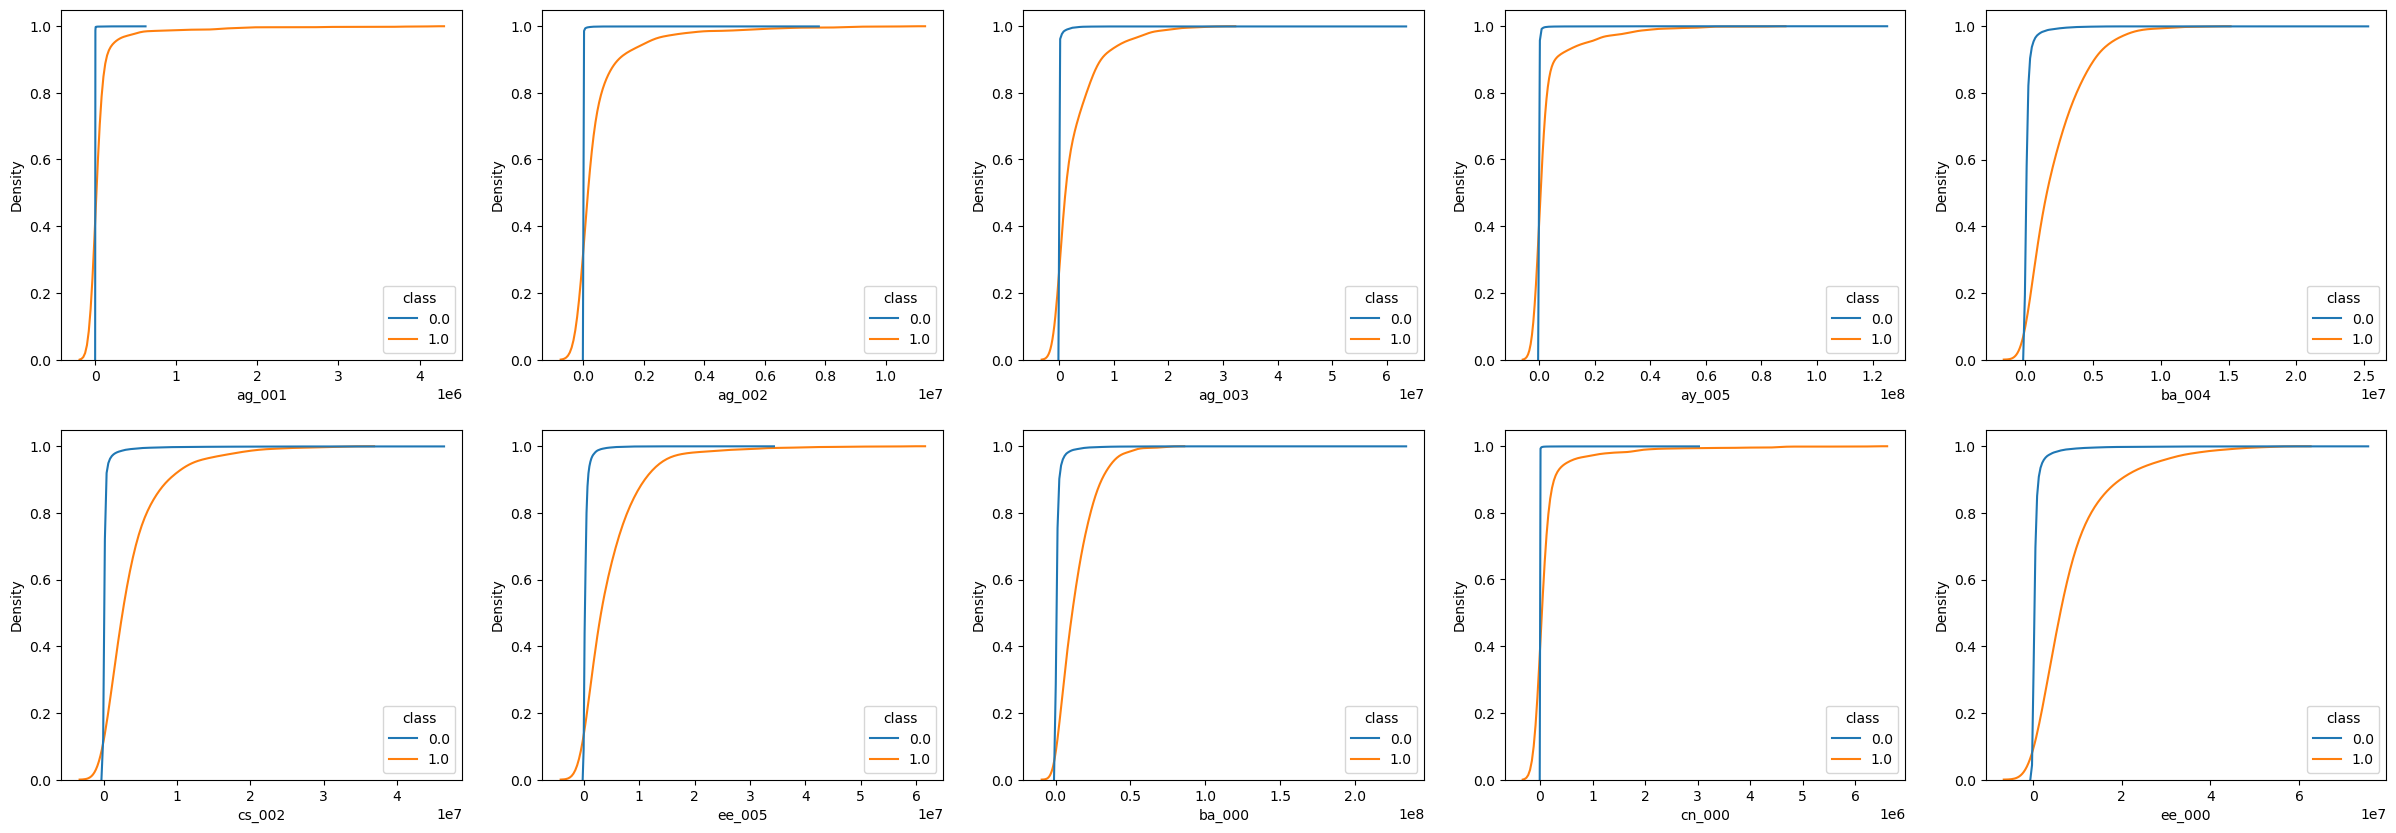

In [38]:
def cdf(df,features,row,col):
  k=0
  fig,axes = plt.subplots(row,col,figsize=(30,10))
  for i in range(len(axes)):
    for j in range(len(axes[0])):
      # plotando PDF e CDF 
      sns.kdeplot(x=df[features[k]], data=df, hue='class', cumulative=True, common_norm=False, ax = axes[i][j])
      if k!= len(features)-1:
        k+=1
      else:
        break
  plt.show()
  plt.savefig('img/cdf_hist.png')
  plt.close()

cdf(hist_features,top_hist_features,2,5)

# 6. Modelling

# 7. Communication